# Image segmentation
- Use metadata in training algorithm
- 

In [1]:
import os
import glob

import pydicom
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

from src.mask_functions import rle2mask
from src.train_utils import *
from src.unet import *
from src.fcn import *

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [2]:
get_available_gpus()

['/device:GPU:0', '/device:GPU:1']

In [6]:
# validate downloaded data against csv

train_annotations = "/home/eoconnell/datasets/kaggle/pneumothorax_segmentation/train-rle.csv"
train_data_loc = "/home/eoconnell/datasets/kaggle/pneumothorax_segmentation/dicom-images-train/"

df = pd.read_csv(train_annotations, skipinitialspace=True)
df.describe()

,ImageId,EncodedPixels
count,11582,11582
unique,10675,3287
top,1.2.276.0.7230010.3.1.4.8323329.1851.151787516...,-1
freq,10,8296


In [58]:
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


## remove rows that don't have images

In [59]:
train_data = [x for x in glob.glob(train_data_loc + "*/*/*.dcm")]

print("number of dicom images: {}".format(len(train_data)))

drop_indexes = []

for index, row in tqdm(enumerate(df["ImageId"].values)):
    if not any(row in s.split("/")[-1][:-4] for s in train_data):
        drop_indexes.append(index)
        df.drop(axis='0', index=index, inplace=True)
        print("dropped index {} with value {}".format(index, row))

print("Number of valid images annotations: {}".format(len(df["ImageId"].values)))

number of dicom images: 10673


KeyboardInterrupt: 

In [5]:
df.describe()
df["ImageId"].value_counts()

NameError: name 'df' is not defined

## Display random images

1.2.276.0.7230010.3.1.4.8323329.32639.1517875161.579169
['/home/eoconnell/datasets/kaggle/pneumothorax_segmentation/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.32639.1517875161.579168/1.2.276.0.7230010.3.1.3.8323329.32639.1517875161.579167/1.2.276.0.7230010.3.1.4.8323329.32639.1517875161.579169.dcm']
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.32639.1517875161.579169
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 00

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  app.launch_new_instance()


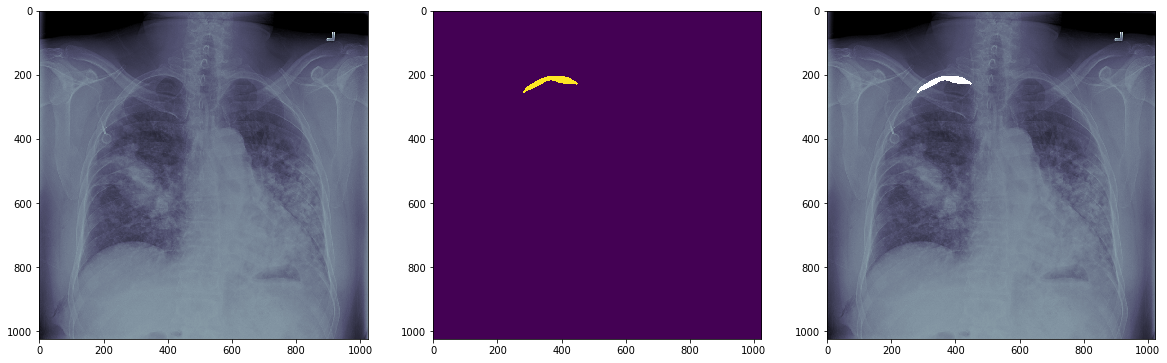

In [28]:
%matplotlib inline

def display_image_and_mask(ImageId, rle):
    train_data = glob.glob(train_data_loc + "*/*/{}.dcm".format(ImageId))
    
    print(ImageId)
    print(train_data)
    
    ds = pydicom.dcmread(train_data[0])
    print(ds)
    img = ds.pixel_array
    print(img.shape)
    
    width, height = img.shape
    
    mask = rle2mask(rle, width, height).astype("Bool")
    img_w_mask = img.copy()
    img_w_mask[mask] = 255
    
    fig, ax = plt.subplots(1, 3)
    
    fig.set_figwidth(20)
    fig.set_figheight(10)
    
    ax[0].imshow(img, cmap=plt.cm.bone)
    ax[1].imshow(mask)
    ax[2].imshow(img_w_mask, cmap=plt.cm.bone)
    
    
while True:
    sample = df.sample(n=1)
    if sample.EncodedPixels.values[0] == "-1":
        continue
    else:
        break

image_id, encoded_pixels = sample.ImageId.values[0], sample.EncodedPixels.values[0]
display_image_and_mask(image_id, encoded_pixels)

## 

In [9]:
# Count num masks
def image_has_mask(encoded_pixels):
    if encoded_pixels == "-1":
        return False
    return True

df["has_mask"] = df.apply(lambda row: image_has_mask(row.EncodedPixels), axis=1)
df["has_mask"].value_counts()

False    8295
True     3285
Name: has_mask, dtype: int64

In [10]:
# average size of masks in pixels
width, height = 1024, 1024

def size_of_mask(encoded_pixels):
    if encoded_pixels == "-1":
        return 0
    mask = rle2mask(encoded_pixels, width, height).astype(int)
    return np.sum(mask)

df["mask_size"] = df.apply(lambda row: size_of_mask(row.EncodedPixels), axis=1)
df[df["has_mask"] == True].describe()

,mask_size
count,3285.000000
mean,10837.930594
std,13463.205173
min,55.000000
25%,3180.000000
50%,6250.000000
75%,13117.000000
max,161421.000000


# Prepare training data

In [ ]:
def prepare_train_data(dataframe, file_loc):
    x_data, y_data = [], []
    
    for index, row in tqdm(dataframe.iterrows()):
        image_name, rle = row.ImageId, row.EncodedPixels
        img_loc = glob.glob(file_loc + "*/*/{}.dcm".format(image_name))[0]
        
        img = pydicom.dcmread(img_loc).pixel_array
        img = cv2.resize(img, (256, 256))
        
        x_data.append(img)
        
        if rle == "-1":
            mask = np.zeros((256, 256))
        else:
            mask = rle2mask(rle, 256, 256)
        
        y_data.append(mask)
    
    x_data = np.stack(x_data)
    y_data = np.stack(y_data)
    
    return x_data, y_data

x_data, y_data = prepare_train_data(df[df["has_mask"] == True], train_data_loc)

np.save("x_data_all_mask", x_data)
np.save("y_data_all_mask", y_data)

# Training script

In [2]:
x_data = np.load("x_data_all_mask.npy").reshape((3285, 256, 256, 1)).astype("float")
y_data = np.load("y_data_all_mask.npy").reshape((3285, 256, 256, 1)).astype("float")

x_data /= 255.

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42)

print("Size of train dataset: {}".format(x_train.shape[0]))
print("Size of test dataset: {}".format(x_test.shape[0]))


print(x_data.shape)
print(x_train.shape)
print(x_test.shape)

print(y_data.shape)
print(y_train.shape)
print(y_test.shape)

Size of train dataset: 2628
Size of test dataset: 657
(3285, 256, 256, 1)
(2628, 256, 256, 1)
(657, 256, 256, 1)
(3285, 256, 256, 1)
(2628, 256, 256, 1)
(657, 256, 256, 1)


# Training script

In [4]:
batch_size = 1
nb_epoch = 100
lr_base = 0.01

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

model = unet()
model.summary()

adam_optimizer=tf.train.AdamOptimizer()#learning_rate=lr_base)

model.compile(loss="binary_crossentropy",
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['binary_crossentropy', dice_coef])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="./model_dir")


history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    callbacks=[tensorboard_callback],
                    workers=4
                   )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

Epoch 1/100
2628/2628 [==============================] - 191s 73ms/sample - loss: nan - binary_crossentropy: nan - dice_coef: 0.0081 - val_loss: nan - val_binary_crossentropy: nan - val_dice_coef: 0.0011
Epoch 2/100
2628/2628 [==============================] - 190s 72ms/sample - loss: nan - binary_crossentropy: nan - dice_coef: 5.3905e-04 - val_loss: nan - val_binary_crossentropy: nan - val_dice_coef: 0.0011
Epoch 3/100
2628/2628 [==============================] - 190s 72ms/sample - loss: nan - binary_crossentropy: nan - dice_coef: 5.3905e-04 - val_loss: nan - val_binary_crossentropy: nan - val_dice_coef: 0.0011
Epoch 4/100
2628/2628 [==============================] - 190s 72ms/sample - loss: nan - binary_crossentropy: nan - dice_coef: 5.3905e-04 - val_loss: nan - val_binary_crossentropy: nan - val_dice_coef: 0.0011
Epoch 5/100
2628/2628 [==============================] - 190s 72ms/sample - loss: nan - binary_crossentropy: nan - dice_coef: 5.3905e-04 - val_loss: nan - val_binary_crosse

KeyboardInterrupt: 